In [1]:
from sklearn import neighbors
from sklearn import preprocessing
from arch.bootstrap import StationaryBootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import sys
import random
from itertools import chain

In [10]:
#read training and cross validation set
total = pd.read_csv("time_space.csv")
n = total.shape[0]
num_tract = 1758

total = total.drop(total.columns[0], axis = 1) #delete index

tract_id = total['GEOID']
total = total.drop(total.columns[0], axis = 1) #delete tract_geoid
    
mp_date = total['MP_DATE']
origin = dt.datetime.strptime(total.loc[0, 'MP_DATE'],'%Y-%m-%d').date()
for i in range(n):
    now = dt.datetime.strptime(total.loc[i, 'MP_DATE'],'%Y-%m-%d').date()
    total.loc[i, 'MP_DATE'] = (now - origin).days/30.0    
values = total['values']
total = total.drop(total.columns[3], axis = 1) #delete values

test = pd.read_csv("test_data.csv")
m = test.shape[0]
test = test.drop(test.columns[0], axis = 1) #delete index
test_geoid = test['GEOID']
test = test.drop(test.columns[0], axis = 1) #delete GEOID
for i in range(m):
    now = dt.datetime.strptime(test.loc[i, 'MP_DATE'],'%Y-%m-%d').date()
    test.loc[i, 'MP_DATE'] = (now - origin).days/30.0

In [4]:
#scale latitudes and lontitudes
original_mpdate = total['MP_DATE']
original_lat = total['lat']
original_lon = total['lon']
original_lat_test = test['lat']
original_lon_test = test['lon']
weight = 20


total['lat'] = weight * total['lat']
total['lon'] = weight * total['lon']
test['lat'] = weight * test['lat']
test['lon'] = weight * test['lon']

#set the number of ensemble samples
s = 10 

In [59]:
for blocksize in range(25):
    print("Current Block Size: "+str(blocksize))
    
    #get 10 block bootstrapping samples
    for j in range(num_tract):
        sub_data = total.iloc[63*j:63*(j+1)]
        bs = StationaryBootstrap(blocksize, sub_data)
        if j == 0:
            train_lst = [data[0][0] for data in bs.bootstrap(s)]
        else:
            i = 0
            for data in bs.bootstrap(s):
                train_lst[i] = train_lst[i].append(data[0][0])
                i += 1
    print("Finish Bootstrapping")

    #find best k for each bootstrapping sample --> model parameter
    best_k_lst = []
    best_mae_lst = []
    symbol_lst = []
    y_ = []
    loss_per_tract = []
    for i in range(10):
        train_y = train_lst[i]['dv'] #get dependent variable
        train_x = train_lst[i].drop(train_lst[i].columns[3], axis = 1) #delete dependent variables

        best_mae = sys.maxsize
        for k in range(1, 11, 1):
            knn = neighbors.KNeighborsRegressor(k, weights ='distance')
            y_ = []
            y_mean = 0
            y_symbol = 0
            mae_tract_k = []
            cv_times = range(50,62)
        
            for cv_time in cv_times:
                train_id = list(chain.from_iterable([list(range(63*k,(63*k+cv_time))) for k in range(num_tract)]))
                test_id = [63*k+cv_time for k in range(num_tract)]

                y_predict = knn.fit(train_x.iloc[train_id], train_y.iloc[train_id]).predict(train_x.iloc[test_id])
                y_ += [y_predict]
                mae_tract_k += [abs(y_predict - train_y.iloc[test_id])]
                mae = np.mean(abs(y_predict - train_y.iloc[test_id]))
                y_mean += mae
                y_symbol += sum(y_predict*train_y.iloc[test_id]>=0)/len(y_predict)
        
            mae_tract_k = np.array(mae_tract_k)
            mae_tract_k = list(np.mean(mae_tract_k,axis=0))
            y_mean = y_mean / len(cv_times)
            y_symbol = y_symbol / len(cv_times)
            if y_mean < best_mae:
                best_mae = y_mean
                best_k = k
                symbol = y_symbol
                mae_tract = mae_tract_k
                print((i, k, best_mae))
            
        loss_per_tract.append([mae_tract])
        best_mae_lst.append(best_mae)
        best_k_lst.append(best_k)
        symbol_lst.append(symbol)
    
    loss_per_tract = np.array(loss_per_tract)
    loss_per_tract = list(np.mean(loss_per_tract,axis=0))


Current Block Size: 0


ZeroDivisionError: float division by zero

In [69]:
blocksize = 12
#get 10 block bootstrapping samples
for j in range(num_tract):
    sub_data = total.iloc[63*j:63*(j+1)]
    bs = StationaryBootstrap(blocksize, sub_data)
    if j == 0:
        train_lst = [data[0][0] for data in bs.bootstrap(s)]
    else:
        i = 0
        for data in bs.bootstrap(s):
            train_lst[i] = train_lst[i].append(data[0][0])
            i += 1
print("Finish Bootstrapping")

Finish Bootstrapping


In [70]:
#find best k for each bootstrapping sample --> model parameter
best_k_lst = []
best_mae_lst = []
symbol_lst = []
y_ = []
loss_per_tract = []
for i in range(10):
    train_y = train_lst[i]['dv'] #get dependent variable
    train_x = train_lst[i].drop(train_lst[i].columns[3], axis = 1) #delete dependent variables

    best_mae = sys.maxsize
    for k in range(1, 11, 1):
        knn = neighbors.KNeighborsRegressor(k, weights ='distance')
        y_ = []
        y_mean = 0
        y_symbol = 0
        mae_tract_k = []
        cv_times = range(50,62)
        
        for cv_time in cv_times:
            train_id = list(chain.from_iterable([list(range(63*k,(63*k+cv_time))) for k in range(num_tract)]))
            test_id = [63*k+cv_time for k in range(num_tract)]
            #print(test_id)
            y_predict = knn.fit(train_x.iloc[train_id], train_y.iloc[train_id]).predict(train_x.iloc[test_id])
            y_ += [y_predict]
            mae_tract_k += [abs(y_predict - train_y.iloc[test_id])]
            mae = np.mean(abs(y_predict - train_y.iloc[test_id]))
            y_mean += mae
            y_symbol += sum(y_predict*train_y.iloc[test_id]>=0)/len(y_predict)
        
        mae_tract_k = np.array(mae_tract_k)
        mae_tract_k = list(np.mean(mae_tract_k,axis=0))
        y_mean = y_mean / len(cv_times)
        y_symbol = y_symbol / len(cv_times)
        if y_mean < best_mae:
            best_mae = y_mean
            best_k = k
            symbol = y_symbol
            mae_tract = mae_tract_k
            print((i, k, best_mae))
            
    loss_per_tract.append([mae_tract])
    best_mae_lst.append(best_mae)
    best_k_lst.append(best_k)
    symbol_lst.append(symbol)
    
loss_per_tract = np.array(loss_per_tract)
loss_per_tract = list(np.mean(loss_per_tract,axis=0))

(0, 1, 2.0042702380669906)
(1, 1, 1.3582520897381214)
(2, 1, 1.9353744047775405)
(2, 2, 1.8110884286415498)
(2, 4, 1.7768986481332638)
(3, 1, 1.3793996968673088)
(3, 2, 1.2978307693996636)
(4, 1, 2.608210511987217)
(4, 2, 2.169623252729781)
(4, 3, 2.042451293427677)
(5, 1, 2.2497885485534135)
(5, 2, 2.0948967685859112)
(6, 1, 3.056937774015045)
(6, 2, 3.0477063315162387)
(7, 1, 1.6545803263847552)
(8, 1, 1.4813951392644915)
(9, 1, 1.9544616863257618)
(9, 2, 1.7384507193036287)
(9, 3, 1.7121985647871238)


In [71]:
best_k_lst

[1, 1, 4, 2, 3, 2, 2, 1, 1, 3]

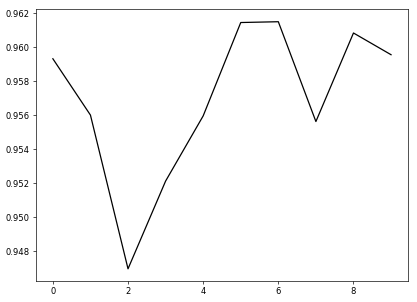

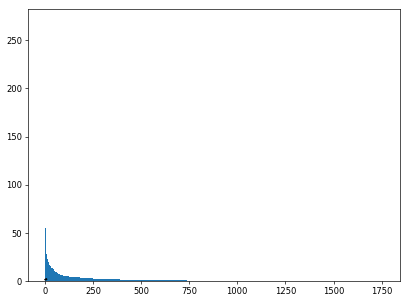

In [72]:
loss_per_tract_final = loss_per_tract[0]
loss_per_tract_final = sorted(loss_per_tract_final,reverse=True)

import matplotlib.pyplot as plt
plt.bar(range(len(loss_per_tract_final)),loss_per_tract_final,width=1)
plt.show()

In [73]:
#draw correct rate
plt.figure(figsize=(8,6), dpi=60)
plt.plot(range(10), symbol_lst, 'k')
plt.savefig("final_results/accuracy.png", dpi = 60)
np.mean(symbol_lst)

0.96063708759954503

In [ ]:
#draw MAE
plt.figure(figsize=(8,6), dpi=60)
plt.plot(range(10), best_mae_lst, 'k')
plt.savefig("final_results/MAE.png", dpi = 60)
np.mean(best_mae_lst)

1.8470480169304235

In [65]:
#train_lst_origin = train_lst

In [ ]:
#get predictions
y_pre_lst = []
y_final_pre = []
test_times = range(0,12)
for test_time in test_times:
    test_id = [12*k+test_time for k in range(num_tract)]
    y_pre_k = []
    #print(test_id)
    
    
    for i in range(10):
        train_y = train_lst[i]['dv'] #get dependent variable
        #print(train_y.shape[0])
        train_x = train_lst[i].drop(train_lst[i].columns[3], axis = 1) #delete dependent variables
        #print(train_x.shape[0])
        knn = neighbors.KNeighborsRegressor(best_k_lst[i], weights ='distance')
        y_pre = knn.fit(train_x, train_y).predict(test.iloc[test_id])
        y_pre_k += [y_pre]
        
        print((test_time,i,train_x.shape[0]))
       
        
        for j in range(num_tract):
            insert = []
            insert += list(test.iloc[test_id[j]])
            insert.append(y_pre[j])
            train_lst[i].loc[train_x.shape[0]+j] = insert

        
       
    
    y_pre_tract = np.array(y_pre_k)
    y_pre_tract = list(np.mean(y_pre_tract,axis=0))
    y_final_pre.append([y_pre_tract])
    
    #for i in range(num_tract):
    #    train_x
        
    #    y_pre_lst.append(y_pre)
    #y_pre_mat = np.array(y_pre_lst)
    #y_final_pre = np.mean(y_pre_mat, 0)

(0, 0, 110754)
(0, 1, 110754)
(0, 2, 110754)
(0, 3, 110754)
(0, 4, 110754)
(0, 5, 110754)
(0, 6, 110754)
(0, 7, 110754)
(0, 8, 110754)
(0, 9, 110754)
(1, 0, 112512)
(1, 1, 112512)
(1, 2, 112512)
(1, 3, 112512)
(1, 4, 112512)
(1, 5, 112512)
(1, 6, 112512)
(1, 7, 112512)
(1, 8, 112512)
(1, 9, 112512)
(2, 0, 114270)
(2, 1, 114270)
(2, 2, 114270)
(2, 3, 114270)
(2, 4, 114270)
(2, 5, 114270)
(2, 6, 114270)
(2, 7, 114270)
(2, 8, 114270)
(2, 9, 114270)
(3, 0, 116028)
(3, 1, 116028)
(3, 2, 116028)
(3, 3, 116028)
(3, 4, 116028)
(3, 5, 116028)
(3, 6, 116028)


In [67]:
y_final_pre = []
y_final_pre.append([y_pre_tract])

In [33]:
# draw graphs to show predictions of each tract
for i in range(1758):
    filename = "final_results/figure/%d.png" % i
    plt.figure(figsize=(8,6), dpi=60)
    plt.plot(range(12), y_final_pre[i*12:(i+1)*12], 'k')
    plt.savefig(filename, dpi = 60)

NameError: name 'y_final_pre' is not defined

In [90]:
#output average increase rates for each tract
unique_tract = list((set(tract_id)))
tract_rate = []
for i in range(1758):
    future_rate = y_final_pre[i*12:(i+1)*12]
    tract_rate.append(np.mean(future_rate))
data = {'Future Annual Increase Rate': tract_rate,
        'TRACT_GEOID': unique_tract}
df = pd.DataFrame(data, index = range(1, 1759, 1))
df.to_csv('final_results/final_prediction.csv')

In [91]:
# final recommendations
recommend = dict()
recommend['invest'] = []
recommend['hold'] = []
recommend['divest'] = []
unique_tract = list((set(tract_id)))
tract_rate = []
for i in range(1758):
    future_rate = y_final_pre[i*12:(i+1)*12]
    tract_rate.append(np.mean(future_rate))
    if future_rate[1] < future_rate[0]:
        recommend['divest'].append(unique_tract[i])
    elif future_rate[0] > 0.2:
        recommend['invest'].append(unique_tract[i])
    else:
        recommend['hold'].append(unique_tract[i])

In [100]:
#output invest decisions for each tract
n_1 = len(recommend['divest'])
n_2 = len(recommend['hold'])
n_3 = len(recommend['invest'])
n_max = max(n_1, n_2, n_3)
for i in range(n_max - n_2):
    recommend['hold'].append(0)
for i in range(n_max - n_3):
    recommend['invest'].append(0)
df_2 = pd.DataFrame(recommend, index = range(1, n_max+1, 1))
df_2.to_csv('invest_decisions.csv')

In [103]:
new_df = dict()
for tract in unique_tract:
    if tract in recommend['invest']:
        new_df[tract] = 3
    elif tract in recommend['hold']:
        new_df[tract] = 2
    else:
        new_df[tract] = 1
final_df = dict()
final_df['GEOID'] = [k for k in new_df.keys()]
final_df['decision'] = [v for v in new_df.values()]

In [105]:
df_3 = pd.DataFrame(final_df, index = range(1, 1759, 1))
df_3.to_csv('final_results/tract_decisions.csv')

In [108]:
test['lon']

0       -1477.671380
1       -1477.671380
2       -1477.671380
3       -1477.671380
4       -1477.671380
5       -1477.671380
6       -1477.671380
7       -1477.671380
8       -1477.671380
9       -1477.671380
10      -1477.671380
11      -1477.671380
12      -1478.192430
13      -1478.192430
14      -1478.192430
15      -1478.192430
16      -1478.192430
17      -1478.192430
18      -1478.192430
19      -1478.192430
20      -1478.192430
21      -1478.192430
22      -1478.192430
23      -1478.192430
24      -1478.515976
25      -1478.515976
26      -1478.515976
27      -1478.515976
28      -1478.515976
29      -1478.515976
            ...     
21066   -1483.266650
21067   -1483.266650
21068   -1483.266650
21069   -1483.266650
21070   -1483.266650
21071   -1483.266650
21072   -1483.311741
21073   -1483.311741
21074   -1483.311741
21075   -1483.311741
21076   -1483.311741
21077   -1483.311741
21078   -1483.311741
21079   -1483.311741
21080   -1483.311741
21081   -1483.311741
21082   -1483